### Notebook to explore how adding a hidden layer affects decoder performance

### Setup

In [1]:
# Try to decode which feature was selected per-trial based on firing rates of neurons
# experiment with ranges of firing rates around fixation (selection) time

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import scipy.stats
from lfp_tools import (
    general as lfp_general,
    startup as lfp_startup,
    development as lfp_development,
    analysis as lfp_analysis
)
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import s3fs
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils
import utils.io_utils as io_utils
from trial_splitters.random_splitter import RandomSplitter
from trial_splitters.block_splitter import BlockSplitter
from trial_splitters.kfold_splitter import KFoldSplitter
from sklearn import svm
from sklearn.linear_model import LogisticRegression
import pickle

from models.value_models import ValueNormedModel, ValueNormedHiddenModel
from models.model_wrapper import ModelWrapper

from models.trainer import Trainer

import torch

import plotly.express as px


matplotlib.rcParams['figure.dpi'] = 150


species = 'nhp'
subject = 'SA'
exp = 'WCST'
session = 20180802  # this is the session for which there are spikes at the moment. 

feature_dims = ["Color", "Shape", "Pattern"]

pre_interval = 1300
post_interval = 1500

In [2]:
# grab behavioral data, spike data, trial numbers. 
fs = s3fs.S3FileSystem()
behavior_file = spike_general.get_behavior_path(subject, session)
behavior_data = pd.read_csv(fs.open(behavior_file))
valid_beh = behavior_data[behavior_data.Response.isin(["Correct", "Incorrect"])]   
shuffled_card_idxs = behavioral_utils.get_shuffled_card_idxs(valid_beh)
valid_beh = valid_beh[valid_beh.TrialNumber >= 57]

In [3]:
firing_rates = pd.read_pickle(fs.open("l2l.pqz317.scratch/firing_rates_1300_fb_1500_100_bins.pickle"))

In [4]:
num_neurons = len(firing_rates.UnitID.unique())
labels = np.sort(shuffled_card_idxs.ItemChosen.unique())
init_params = {"n_inputs": num_neurons, "n_values": 12}
# init_params = {"n_inputs": num_neurons, "n_values": 12}

trainer = Trainer(learning_rate=0.05, max_iter=500, batch_size=10000)
wrapped = ModelWrapper(ValueNormedModel, init_params, trainer, labels)
# wrapped = ModelWrapper(ValueNormedModel, init_params, trainer, labels)

mode = "SpikeCounts"

# prep data for classification
inputs = firing_rates.rename(columns={mode: "Value"})
labels = shuffled_card_idxs.rename(columns={"ItemChosen": "Feature"})

random_splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)

outputs = classifier_utils.evaluate_classifiers_by_time_bins(
    wrapped, inputs, labels, np.arange(0, 2.8, 0.1), random_splitter, cards=shuffled_card_idxs
)
io_utils.save_model_outputs(
    fs, 
    "value_model_original", 
    f"{pre_interval}_fb_{post_interval}",
    "random_split",
    outputs
)

Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001
Evaluating for bin 0.8
Evaluating for bin 0.9
Evaluating for bin 1.0
Evaluating for bin 1.1
Evaluating for bin 1.2000000000000002
Evaluating for bin 1.3
Evaluating for bin 1.4000000000000001
Evaluating for bin 1.5
Evaluating for bin 1.6
Evaluating for bin 1.7000000000000002
Evaluating for bin 1.8
Evaluating for bin 1.9000000000000001
Evaluating for bin 2.0
Evaluating for bin 2.1
Evaluating for bin 2.2
Evaluating for bin 2.3000000000000003
Evaluating for bin 2.4000000000000004
Evaluating for bin 2.5
Evaluating for bin 2.6
Evaluating for bin 2.7


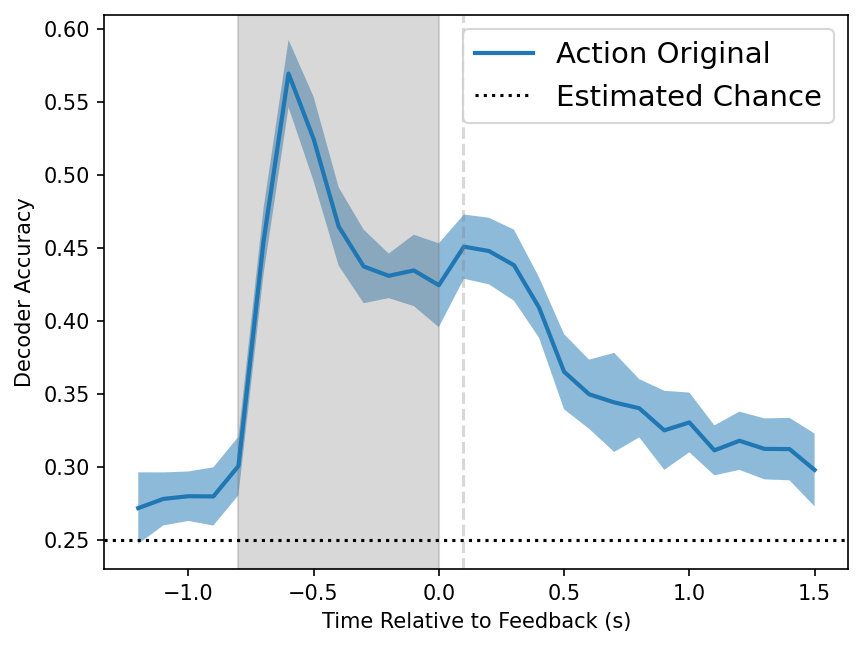

In [5]:
_, test_accs_by_bin, _, _, _ = io_utils.load_model_outputs(
    fs, 
    "value_model_original", 
    f"{pre_interval}_fb_{post_interval}",
    "random_split",
)

fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_across_time_bins(
    test_accs_by_bin,
    1.3, 1.5, 0.1,
    ax,
    label="Action Original",
    right_align=True, 
    # color='black'
)

ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("Decoder Accuracy")
ax.legend(prop={'size': 14})

### Train for different Hidden Layers

#### 12 Hidden Units

In [ ]:
num_neurons = len(firing_rates.UnitID.unique())
labels = np.sort(shuffled_card_idxs.ItemChosen.unique())
init_params = {"n_inputs": num_neurons, "n_hidden": 12, "n_values": 12}
# init_params = {"n_inputs": num_neurons, "n_values": 12}

trainer = Trainer(learning_rate=0.05, max_iter=500, batch_size=10000)
wrapped = ModelWrapper(ValueNormedHiddenModel, init_params, trainer, labels)
# wrapped = ModelWrapper(ValueNormedModel, init_params, trainer, labels)

mode = "SpikeCounts"

# prep data for classification
inputs = firing_rates.rename(columns={mode: "Value"})
labels = shuffled_card_idxs.rename(columns={"ItemChosen": "Feature"})

random_splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)

outputs = classifier_utils.evaluate_classifiers_by_time_bins(
    wrapped, inputs, labels, np.arange(0, 2.8, 0.1), random_splitter, cards=shuffled_card_idxs
)
io_utils.save_model_outputs(
    fs, 
    "value_model_hidden_12", 
    f"{pre_interval}_fb_{post_interval}",
    "random_split",
    outputs
)

#### 6 hidden Units

In [ ]:
num_neurons = len(firing_rates.UnitID.unique())
labels = np.sort(shuffled_card_idxs.ItemChosen.unique())
init_params = {"n_inputs": num_neurons, "n_hidden": 6, "n_values": 12}
# init_params = {"n_inputs": num_neurons, "n_values": 12}

trainer = Trainer(learning_rate=0.05, max_iter=500, batch_size=10000)
wrapped = ModelWrapper(ValueNormedHiddenModel, init_params, trainer, labels)
# wrapped = ModelWrapper(ValueNormedModel, init_params, trainer, labels)

mode = "SpikeCounts"
# prep data for classification
inputs = firing_rates.rename(columns={mode: "Value"})
labels = shuffled_card_idxs.rename(columns={"ItemChosen": "Feature"})

random_splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)

outputs = classifier_utils.evaluate_classifiers_by_time_bins(
    wrapped, inputs, labels, np.arange(0, 2.8, 0.1), random_splitter, cards=shuffled_card_idxs
)
io_utils.save_model_outputs(
    fs, 
    "value_model_hidden_6", 
    f"{pre_interval}_fb_{post_interval}",
    "random_split",
    outputs
)

#### 3 hidden Units

In [13]:
num_neurons = len(firing_rates.UnitID.unique())
labels = np.sort(shuffled_card_idxs.ItemChosen.unique())
init_params = {"n_inputs": num_neurons, "n_hidden": 3, "n_values": 12}

trainer = Trainer(learning_rate=0.05, max_iter=500, batch_size=10000)
wrapped = ModelWrapper(ValueNormedHiddenModel, init_params, trainer, labels)

mode = "SpikeCounts"

# prep data for classification
inputs = firing_rates.rename(columns={mode: "Value"})
labels = shuffled_card_idxs.rename(columns={"ItemChosen": "Feature"})

random_splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)

outputs = classifier_utils.evaluate_classifiers_by_time_bins(
    wrapped, inputs, labels, np.arange(0, 2.8, 0.1), random_splitter, cards=shuffled_card_idxs
)
io_utils.save_model_outputs(
    fs, 
    "value_model_hidden_3", 
    f"{pre_interval}_fb_{post_interval}",
    "random_split",
    outputs
)

Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001
Evaluating for bin 0.8
Evaluating for bin 0.9
Evaluating for bin 1.0
Evaluating for bin 1.1
Evaluating for bin 1.2000000000000002
Evaluating for bin 1.3
Evaluating for bin 1.4000000000000001
Evaluating for bin 1.5
Evaluating for bin 1.6
Evaluating for bin 1.7000000000000002
Evaluating for bin 1.8
Evaluating for bin 1.9000000000000001
Evaluating for bin 2.0
Evaluating for bin 2.1
Evaluating for bin 2.2
Evaluating for bin 2.3000000000000003
Evaluating for bin 2.4000000000000004
Evaluating for bin 2.5
Evaluating for bin 2.6
Evaluating for bin 2.7


In [19]:
num_neurons = len(firing_rates.UnitID.unique())
labels = np.sort(shuffled_card_idxs.ItemChosen.unique())
init_params = {"n_inputs": num_neurons, "n_hidden": 1, "n_values": 12}

trainer = Trainer(learning_rate=0.05, max_iter=500, batch_size=10000)
wrapped = ModelWrapper(ValueNormedHiddenModel, init_params, trainer, labels)

mode = "SpikeCounts"

# prep data for classification
inputs = firing_rates.rename(columns={mode: "Value"})
labels = shuffled_card_idxs.rename(columns={"ItemChosen": "Feature"})

random_splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)

outputs = classifier_utils.evaluate_classifiers_by_time_bins(
    wrapped, inputs, labels, np.arange(0, 2.8, 0.1), random_splitter, cards=shuffled_card_idxs
)
io_utils.save_model_outputs(
    fs, 
    "value_model_hidden_1", 
    f"{pre_interval}_fb_{post_interval}",
    "random_split",
    outputs
)

Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001
Evaluating for bin 0.8
Evaluating for bin 0.9
Evaluating for bin 1.0
Evaluating for bin 1.1
Evaluating for bin 1.2000000000000002
Evaluating for bin 1.3
Evaluating for bin 1.4000000000000001
Evaluating for bin 1.5
Evaluating for bin 1.6
Evaluating for bin 1.7000000000000002
Evaluating for bin 1.8
Evaluating for bin 1.9000000000000001
Evaluating for bin 2.0
Evaluating for bin 2.1
Evaluating for bin 2.2
Evaluating for bin 2.3000000000000003
Evaluating for bin 2.4000000000000004
Evaluating for bin 2.5
Evaluating for bin 2.6
Evaluating for bin 2.7


#### 2 hiddden units

In [15]:
num_neurons = len(firing_rates.UnitID.unique())
labels = np.sort(shuffled_card_idxs.ItemChosen.unique())
init_params = {"n_inputs": num_neurons, "n_hidden": 2, "n_values": 12}

trainer = Trainer(learning_rate=0.05, max_iter=500, batch_size=10000)
wrapped = ModelWrapper(ValueNormedHiddenModel, init_params, trainer, labels)

mode = "SpikeCounts"

# prep data for classification
inputs = firing_rates.rename(columns={mode: "Value"})
labels = shuffled_card_idxs.rename(columns={"ItemChosen": "Feature"})

random_splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)

outputs = classifier_utils.evaluate_classifiers_by_time_bins(
    wrapped, inputs, labels, np.arange(0, 2.8, 0.1), random_splitter, cards=shuffled_card_idxs
)
io_utils.save_model_outputs(
    fs, 
    "value_model_hidden_2", 
    f"{pre_interval}_fb_{post_interval}",
    "random_split",
    outputs
)

Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001
Evaluating for bin 0.8
Evaluating for bin 0.9
Evaluating for bin 1.0
Evaluating for bin 1.1
Evaluating for bin 1.2000000000000002
Evaluating for bin 1.3
Evaluating for bin 1.4000000000000001
Evaluating for bin 1.5
Evaluating for bin 1.6
Evaluating for bin 1.7000000000000002
Evaluating for bin 1.8
Evaluating for bin 1.9000000000000001
Evaluating for bin 2.0
Evaluating for bin 2.1
Evaluating for bin 2.2
Evaluating for bin 2.3000000000000003
Evaluating for bin 2.4000000000000004
Evaluating for bin 2.5
Evaluating for bin 2.6
Evaluating for bin 2.7


### Plot everything

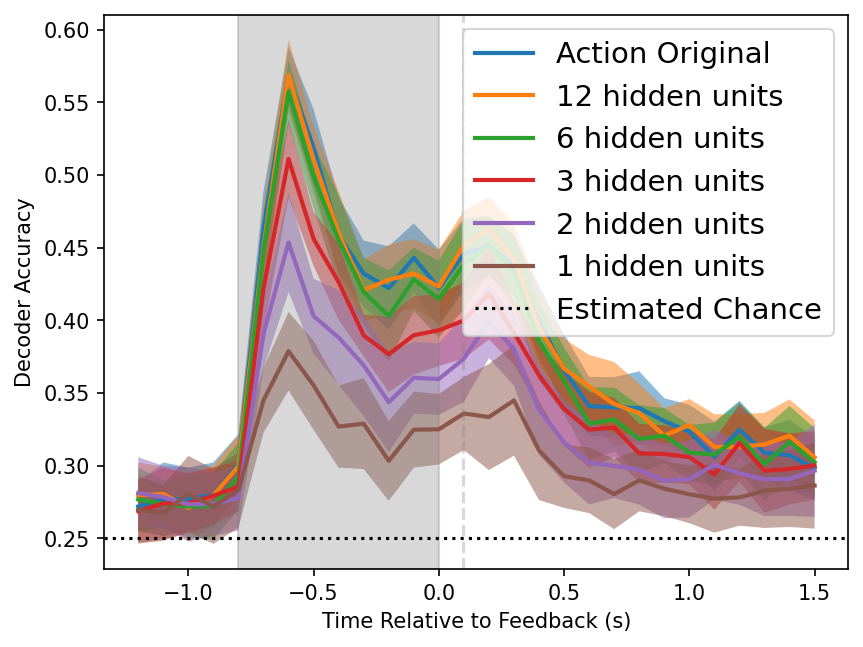

In [20]:
_, test_accs_original, _, _, _ = io_utils.load_model_outputs(
    fs, 
    "value_model_original", 
    f"{pre_interval}_fb_{post_interval}",
    "random_split",
)
_, test_accs_hidden_12, _, _, _ = io_utils.load_model_outputs(
    fs, 
    "value_model_hidden_12", 
    f"{pre_interval}_fb_{post_interval}",
    "random_split",
)
_, test_accs_hidden_6, _, _, _ = io_utils.load_model_outputs(
    fs, 
    "value_model_hidden_6", 
    f"{pre_interval}_fb_{post_interval}",
    "random_split",
)
_, test_accs_hidden_3, _, _, _ = io_utils.load_model_outputs(
    fs, 
    "value_model_hidden_3", 
    f"{pre_interval}_fb_{post_interval}",
    "random_split",
)
_, test_accs_hidden_2, _, _, _ = io_utils.load_model_outputs(
    fs, 
    "value_model_hidden_2", 
    f"{pre_interval}_fb_{post_interval}",
    "random_split",
)
_, test_accs_hidden_1, _, _, _ = io_utils.load_model_outputs(
    fs, 
    "value_model_hidden_1", 
    f"{pre_interval}_fb_{post_interval}",
    "random_split",
)

fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_across_time_bins(
    test_accs_by_bin,
    1.3, 1.5, 0.1,
    ax,
    label="Action Original",
    right_align=True, 
)
visualization_utils.visualize_accuracy_across_time_bins(
    test_accs_hidden_12,
    1.3, 1.5, 0.1,
    ax,
    label="12 hidden units",
    right_align=True, 
)
visualization_utils.visualize_accuracy_across_time_bins(
    test_accs_hidden_6,
    1.3, 1.5, 0.1,
    ax,
    label="6 hidden units",
    right_align=True, 
)
visualization_utils.visualize_accuracy_across_time_bins(
    test_accs_hidden_3,
    1.3, 1.5, 0.1,
    ax,
    label="3 hidden units",
    right_align=True, 
)
visualization_utils.visualize_accuracy_across_time_bins(
    test_accs_hidden_2,
    1.3, 1.5, 0.1,
    ax,
    label="2 hidden units",
    right_align=True, 
)
visualization_utils.visualize_accuracy_across_time_bins(
    test_accs_hidden_1,
    1.3, 1.5, 0.1,
    ax,
    label="1 hidden units",
    right_align=True, 
)

ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("Decoder Accuracy")
ax.legend(prop={'size': 14})